In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import mysql.connector

In [ ]:
db = mysql.connector.connect(host='127.0.0.1',
                             user='root',
                             password='************',
                             database='ecommerce')

cur = db.cursor()

# Basic

## 1. List all unique cities where customers are located.

In [3]:
query1 = ''' select distinct customer_city from customers'''
cur.execute(query1)
data = cur.fetchall()
Data = pd.DataFrame(data)
Data.rename(columns={0:'City'}, inplace=True)
Data

,City
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
...,...
4114,siriji
4115,natividade da serra
4116,monte bonito
4117,sao rafael


## 2. Count the number of orders placed in 2017.

In [4]:
query2 = ''' select count(year(order_purchase_timestamp)) as order_year 
             from orders where year(order_purchase_timestamp) = 2017'''
cur.execute(query2)
data = cur.fetchall()
print('Total orders placed in 2017:', data[0][0])

Total orders placed in 2017: 45101


## 3. Find the total sales per category.

In [5]:
query3 = ''' select products.product_category as category, 
round(sum(payments.payment_value), 2) as sales
from products join order_items on products.product_id = order_items.product_id
join payments on payments.order_id = order_items.order_id
group by category'''
cur.execute(query3)
data = cur.fetchall()
df = pd.DataFrame(data)
df.rename(columns={0:'Category', 1:'Sales'}, inplace=True)
df

,Category,Sales
0,perfumery,506738.66
1,Furniture Decoration,1430176.39
2,telephony,486882.05
3,bed table bath,1712553.67
4,automotive,852294.33
...,...,...
69,cds music dvds,1199.43
70,La Cuisine,2913.53
71,Fashion Children's Clothing,785.67
72,PC Gamer,2174.43


## 4. Calculate the percentage of orders that were paid in more than 1 installment.

In [6]:
query4 = ''' select (sum(case when payment_installments > 1 then 1 else 0 end)) / count(*)*100
from payments'''
cur.execute(query4)
data = cur.fetchall()
data[0][0]

Decimal('49.4176')

## 5. Count the number of customers from each state. 

In [7]:
query5 = ''' select customer_state, count(*) as customers from customers 
group by customer_state;'''
cur.execute(query5)
data = cur.fetchall()
df1 = pd.DataFrame(data)
df1.rename(columns={0:'State', 1:'Customers'}, inplace=True)
df1 = df1.sort_values(by = 'Customers', ascending=False)
df1

,State,Customers
0,SP,41746
4,RJ,12852
2,MG,11635
5,RS,5466
3,PR,5045
1,SC,3637
9,BA,3380
13,DF,2140
8,ES,2033
7,GO,2020


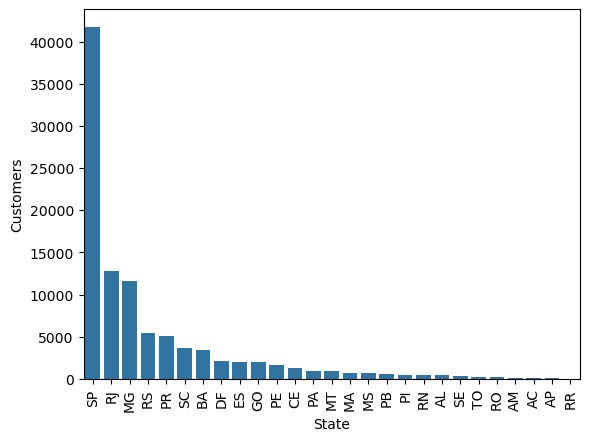

In [8]:
sns.barplot(x=df1['State'], y=df1['Customers'], data=df1)
plt.xticks(rotation = 90)
plt.show()

# Intermediate

## 6. Calculate the number of orders per month in 2018.

In [9]:
query6 = ''' select monthname(order_purchase_timestamp) order_month, 
count(*) as total_orders
from orders where year(order_purchase_timestamp) = 2018
group by order_month
order by total_orders desc'''
cur.execute(query6)
data = cur.fetchall()
df2 = pd.DataFrame(data)
df2.rename(columns={0:'Month', 1:'Orders'}, inplace=True)
df2

,Month,Orders
0,January,7269
1,March,7211
2,April,6939
3,May,6873
4,February,6728
5,August,6512
6,July,6292
7,June,6167
8,September,16
9,October,4


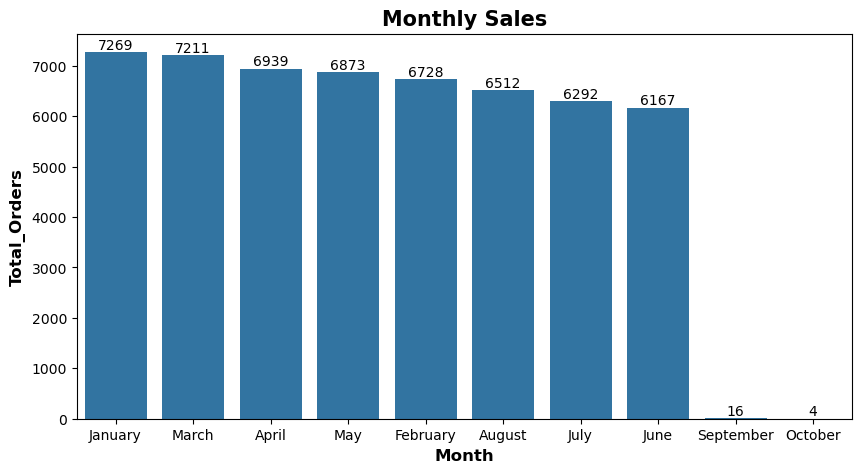

In [10]:
plt.figure(figsize=(10,5))
graph = sns.barplot(x=df2['Month'], y=df2['Orders'], data=df2)

plt.xlabel("Month", fontsize=12, fontweight='bold')
plt.ylabel('Total_Orders', fontsize=12, fontweight='bold')
plt.title('Monthly Sales', fontsize=15, fontweight='bold')

graph.bar_label(graph.containers[0])
plt.show()

## 7. Find the average number of products per order, grouped by customer city.

In [11]:
query7 = ''' with count_per_order as (select orders.order_id, orders.customer_id, count(order_items.order_id) as order_count
from orders
join order_items on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id) 

select customers.customer_city, round(avg(count_per_order.order_count), 2) as average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
order by average_orders desc;'''

cur.execute(query7)
data = cur.fetchall()
df3 = pd.DataFrame(data)
df3.rename(columns={0:'Customer_Name', 1:'Average_Products/Order'}, inplace=True)
df3.head(10)

,Customer_Name,Average_Products/Order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


## 8. Calculate the percentage of total revenue contributed by each product category. 

In [12]:
query8 = ''' select products.product_category as category, 
round((sum(payments.payment_value) / (select sum(payment_value) from payments)) * 100, 2) as total_revenue_percent
from products join order_items on products.product_id = order_items.product_id
join payments on payments.order_id = order_items.order_id
group by category
order by total_revenue_percent desc; '''

cur.execute(query8)
data = cur.fetchall()
df4 = pd.DataFrame(data)
df4.rename(columns={0:'Category', 1:'Revenue_Percentage'}, inplace=True)
df4.head(8)

,Category,Revenue_Percentage
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93
5,sport leisure,8.70
6,housewares,6.84
7,automotive,5.32


## 9. Identify the correlation between product price and the number of times a product has been purchased.

In [13]:
query9 = ''' select products.product_category, count(order_items.product_id), 
round(avg(order_items.price), 2) from products
join order_items on products.product_id = order_items.product_id
group by products.product_category; '''

cur.execute(query9)
data = cur.fetchall()
df5 = pd.DataFrame(data, columns=['Category', 'Order_count', 'Price'])
df5

,Category,Order_count,Price
0,HEALTH BEAUTY,9670,130.16
1,sport leisure,8641,114.34
2,Cool Stuff,3796,167.36
3,computer accessories,7827,116.51
4,Watches present,5991,201.14
...,...,...,...
69,flowers,33,33.64
70,Kitchen portable and food coach,15,264.57
71,House Comfort 2,30,25.34
72,CITTE AND UPHACK FURNITURE,38,114.95


In [14]:
ar1 = df5['Order_count']
ar2 = df5['Price']

correln = np.corrcoef([ar1, ar2])
print("Correlation between order count and price is", round(correln[0][1], 2))

Correlation between order count and price is -0.11


<Axes: xlabel='Order_count', ylabel='Price'>

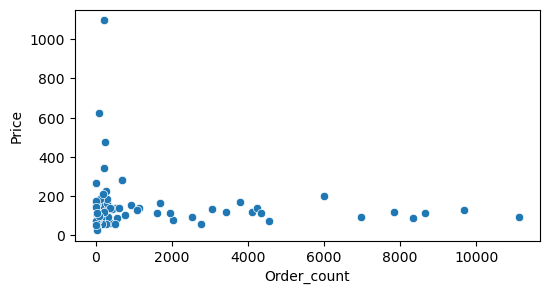

In [15]:
plt.figure(figsize=(6,3))
sns.scatterplot(x=df5['Order_count'], y=df5['Price'], data=df5)

## 10. Calculate the total revenue generated by each seller, and rank them by revenue.

In [16]:
query10 = ''' select *, dense_rank() over(order by revenue desc) as rn from 
(select order_items.seller_id as seller_id, round(sum(payments.payment_value), 2) as revenue from order_items
join payments on order_items.order_id = payments.order_id
group by order_items.seller_id) as a; '''

cur.execute(query10)
data = cur.fetchall()
df6 = pd.DataFrame(data, columns=['Seller ID', 'Revenue', 'Rank'])
df6.head(8)

,Seller ID,Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5
5,da8622b14eb17ae2831f4ac5b9dab84a,272219.32,6
6,4869f7a5dfa277a7dca6462dcf3b52b2,264166.12,7
7,955fee9216a65b617aa5c0531780ce60,236322.30,8


([0, 1, 2, 3, 4],
 [Text(0, 0, '7c67e1448b00f6e969d365cea6b010ab'),
  Text(1, 0, '1025f0e2d44d7041d6cf58b6550e0bfa'),
  Text(2, 0, '4a3ca9315b744ce9f8e9374361493884'),
  Text(3, 0, '1f50f920176fa81dab994f9023523100'),
  Text(4, 0, '53243585a1d6dc2643021fd1853d8905')])

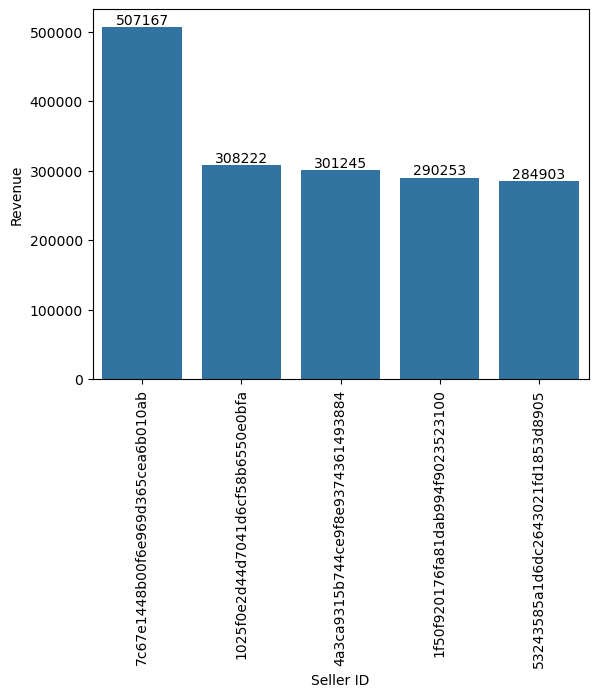

In [17]:
DF = df6.head()
grp = sns.barplot(x='Seller ID', y='Revenue', data=DF)
grp.bar_label(grp.containers[0])
plt.xticks(rotation=90)

# Advance

## 11. Calculate the moving average of order values for each customer over their order history.

In [22]:
query11 = '''select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp , payments.payment_value as payment
from payments join orders on payments.order_id = orders.order_id) as a;'''

cur.execute(query11)
data = cur.fetchall()
df7 = pd.DataFrame(data, columns=['Customer ID', 'Purchase Timestamp', 'Price', 'Mov_Avg_Price'])
df7

,Customer ID,Purchase Timestamp,Price,Mov_Avg_Price
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


## 12. Calculate the cumulative sales per month for each year.

#### Year by Year formula: (Current Sales - Prev Yr Sales) / Prev Yr Sales

In [29]:
query12 = '''select years, months, payment, sum(payment)
over(order by years, months) cumulative_sale
from
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months, 
round(sum(payments.payment_value), 2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a;'''

cur.execute(query12)
data = cur.fetchall()
df8 = pd.DataFrame(data, columns=['Year', 'Month', 'Payment', 'Cumulative_Sale'])
df8.head(8)

,Year,Month,Payment,Cumulative_Sale
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84


## 13. Calculate the year-over-year growth rate of total sales.

In [42]:
query13 = '''with a as (select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value), 2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)
select years, round(((payment - lag(payment, 1) over(order by years)) / 
lag(payment, 1) over(order by years)) * 100, 2) from a;
'''

cur.execute(query13)
data = cur.fetchall()
df9 = pd.DataFrame(data, columns=['Year', 'YoY%Growth'])
df9

,Year,YoY%Growth
0,2016,NaN
1,2017,12112.7
2,2018,20.0


## 14. Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [44]:
query14 = ''' with a as (select customers.customer_id, min(orders.order_purchase_timestamp) as first_order
from customers join orders
on orders.customer_id = customers.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp)
from a join orders on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order, interval 6 month)
group by a.customer_id)

select 100 * (count(distinct a.customer_id) / (count(distinct b.customer_id))) as retention_rate
from a left join b on a.customer_id = b.customer_id; '''

cur.execute(query14)
data = cur.fetchall()
data

[(None,)]

#### Since none of the customers have repeated a purchase under 6 months the output is a null value

## 15. Identify the top 3 customers who spent the most money in each year.

In [46]:
query15 = '''select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) as years, orders.customer_id,
round(sum(payments.payment_value), 2) as payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments
on orders.order_id = payments.order_id
group by year(orders.order_purchase_timestamp), orders.customer_id) as a
where d_rank <=3;'''

cur.execute(query15)
data = cur.fetchall()
df10 = pd.DataFrame(data, columns=['Year', 'Customer_ID', 'Payment', 'Rank'])
df10

,Year,Customer_ID,Payment,Rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,1423.55,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,1400.74,2
2,2016,4a06381959b6670756de02e07b83815f,1227.78,3
3,2017,1617b1357756262bfa56ab541c47bc16,13664.08,1
4,2017,c6e2731c5b391845f6800c97401a43a9,6929.31,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,6726.66,3
6,2018,ec5b2ba62e574342386871631fafd3fc,7274.88,1
7,2018,f48d464a0baaea338cb25f816991ab1f,6922.21,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,4809.44,3


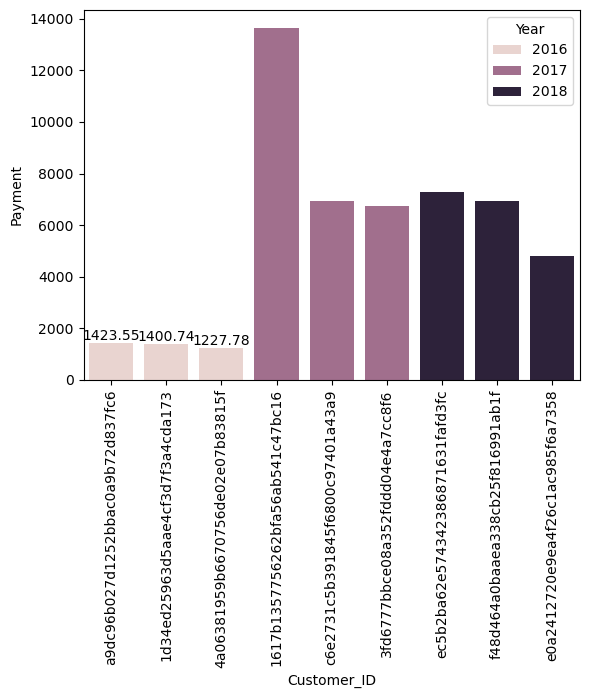

In [50]:
plt.xticks(rotation=90)
plot = sns.barplot(x='Customer_ID', y='Payment', data=df10, hue='Year')
plot = plot.bar_label(plot.containers[0])